In [1]:
%matplotlib inline

# Testing embeddings

Main objective is to see how index-embeddings behave under controlled conditions

In [2]:
import pandas as pd
from fastai2.tabular.all import *
from fastai2 import metrics
from sklearn import ensemble, decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
mpl.style.use("bmh")

## Synthesize data

In [4]:
cat_names = ["id"]
cont_names = [] # ["x"]
dep_var = "y"

n = 1000

In [5]:
generators = {
    "x": lambda x: stats.norm.rvs(loc=-10, scale=1, size=1)[0] if x < .5*n else stats.norm.rvs(loc=10, scale=1, size=1)[0],
    "y": lambda x: 2*float(x)/n - 1
}

df = pd.DataFrame({"id": np.arange(n)})
for k in generators:
    if k in cont_names + cat_names or k == "y":
        df[k] = df["id"].apply(generators[k])
    
df["id"] = pd.Categorical(df["id"])

In [6]:
df.head()

,id,y
0,0,-1.000
1,1,-0.998
2,2,-0.996
3,3,-0.994
4,4,-0.992


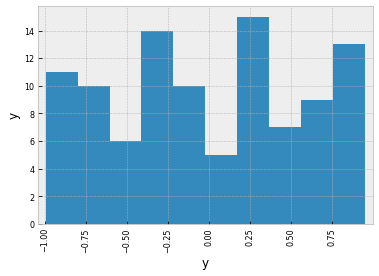

In [7]:
pd.plotting.scatter_matrix(df.sample(n=100));

## Create data loaders

In [8]:
splits = RandomSplitter(valid_pct=.2)(df)
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize], cat_names=cat_names,
                   cont_names=cont_names, y_names=dep_var, splits=splits)

In [9]:
dls = to.dataloaders()

In [10]:
dls.show_batch()

,id,y
0,237,-0.526
1,322,-0.356
2,690,0.380
3,632,0.264
4,392,-0.216
5,436,-0.128
6,62,-0.876
7,489,-0.022
8,230,-0.540
9,88,-0.824


## Create learner

In [11]:
# loss_func = torch.nn.functional.mse_loss
loss_func = mse
learn = tabular_learner(dls, y_range=[df[dep_var].min(), df[dep_var].max()], loss_func=loss_func)

(0.012022644281387329, 0.00363078061491251)

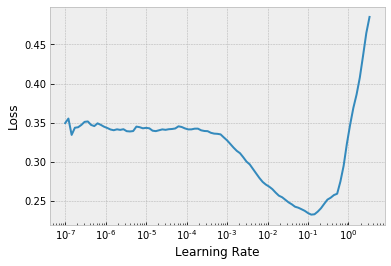

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,time
0,0.408902,0.364143,00:00
1,0.442408,0.362084,00:00
2,0.366168,0.336757,00:00
3,0.300043,0.336286,00:00
4,0.243912,0.336744,00:00


(0.004786301031708717, 2.5118865210060903e-07)

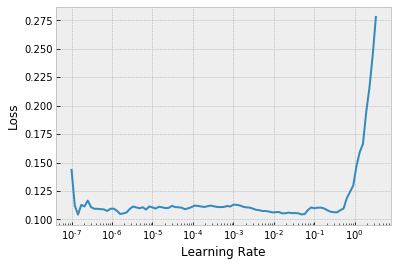

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,0.103333,0.335832,00:00
1,0.104059,0.336541,00:00
2,0.103399,0.342881,00:00
3,0.101940,0.340992,00:00
4,0.101402,0.337961,00:00


(0.02089296132326126, 6.309573450380412e-07)

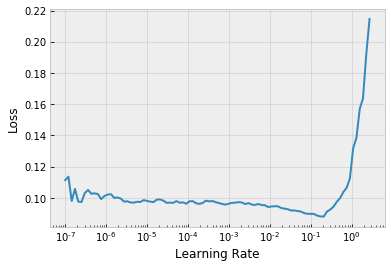

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, lr_max=1e-4)

epoch,train_loss,valid_loss,time
0,0.104326,0.338168,00:00
1,0.101256,0.337803,00:00
2,0.100730,0.337113,00:00
3,0.098945,0.336385,00:00
4,0.097889,0.335893,00:00


## Visualize

In [18]:
col = "id"

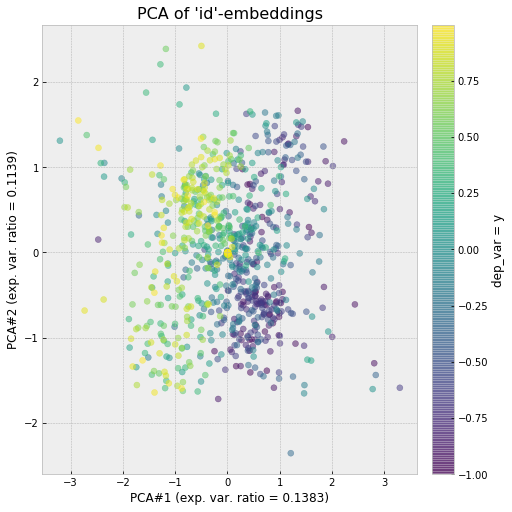

In [20]:
ix = list(to.cat_names).index(col)
X = learn.model.embeds[ix].weight.detach().numpy()
c = [to.classes[col][_i] for _i in to.xs[col].values]

pca = decomposition.PCA(n_components=2)
pca.fit(X)
Xh = pca.transform(X)

fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)
s = ax.scatter(Xh[1:,0], Xh[1:,1], c=df["y"], marker="o", alpha=.5, label="train")
ax.set_title(f"PCA of '{col}'-embeddings", fontsize=16)
ax.set(xlabel=f"PCA#1 (exp. var. ratio = {pca.explained_variance_ratio_[0]:.4f})", 
       ylabel=f"PCA#2 (exp. var. ratio = {pca.explained_variance_ratio_[1]:.4f})",
       )
plt.colorbar(s, label=f"dep_var = {to.ys.columns[0]}")
plt.show()

So we find in the case where the 'id' column is the only input to predict 'y' that there actually is some ordering in the embedding space visible. Color-coding the embedding vectors using the 'y' value we see a relatively clear color gradient